## Setting

- padding_flag: True (add special characters before and after sequences, e.g. 'ACTGAA' -> 'ZZ' + 'ACTGAA' + 'ZZ')
- gap_flag: True (add gapped features-- 3-mer-1-gap)
- weight_flag: False (haven't figure out how to normalise non-square matrix)
- normalised_kernel: zero-mean, unit-norm
- Sum of spectrum kernel (kmer with k = 3): (K_A + K_B + K_C)/3

## Challenging: 

- regression to mean problem
- after normalisation, kernel is still not unit variance

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
from sklearn.model_selection import KFold

def Train_test_split(num_data, test_size = 0.2, random_state = 24):
    np.random.seed(random_state)
    test_idx = np.random.choice(num_data, int(test_size * num_data), replace=False)
    train_idx = list(set(range(num_data)) - set(test_idx))
    
    return np.asarray(train_idx), np.asarray(test_idx)

def Train_val_split(num_data, cv = 5, random_state = 24):
    kf = KFold(n_splits = cv, shuffle = True)
    return kf.split(range(num_data))

def Generate_train_test_data(df, train_idx, test_idx, embedding):
    if 'Rep1' in df.columns:
        train_df = pd.melt(df.loc[train_idx], id_vars=['RBS', 'RBS6', 'AVERAGE', 'STD', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
        train_df = train_df.dropna()
        train_df = train_df.rename(columns = {'value': 'label'})
        test_df = pd.melt(df.loc[test_idx], id_vars=['RBS', 'RBS6', 'AVERAGE', 'STD', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
        test_df = test_df.dropna()
        test_df = test_df.rename(columns = {'value': 'label'})
    else: 
        train_df = df.loc[train_idx]
        test_df = df.loc[test_idx]
        
    X_train = Rewards_env(np.asarray(train_df[['RBS', 'label']]), embedding).embedded
    y_train_sample = np.asarray(train_df['label'])
    y_train_ave = np.asarray(train_df['AVERAGE'])
    
    X_test = Rewards_env(np.asarray(test_df[['RBS', 'label']]), embedding).embedded
    y_test_sample = np.asarray(test_df['label'])
    y_test_ave = np.asarray(test_df['AVERAGE']) 
    
    return X_train, X_test, y_train_sample, y_test_sample, y_train_ave, y_test_ave

In [3]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

# cross validation on training dataset. Find the optimal alpha. 

def cross_val(df, cv = 5, random_state = 24, test_size = 0.2, alpha_list = [0.1, 1],
              kernel = Spectrum_Kernel, embedding = 'label', eva_metric = r2_score, eva_on_ave_flag = True):
    test_scores = []
    
    data = np.asarray(df[['RBS', 'AVERAGE']])
    num_data = data.shape[0]
    
    train_idx, test_idx = Train_test_split(num_data, test_size, random_state)
    X_train, X_test, y_train_sample, y_test_sample, y_train_ave, y_test_ave  = Generate_train_test_data(df, train_idx, test_idx, embedding)

    for train_idx, test_idx in Train_val_split(num_data, cv = cv, random_state = random_state):
        X_train, X_test, y_train_sample, y_test_sample, y_train_ave, y_test_ave  = Generate_train_test_data(df, train_idx, test_idx, embedding)
        cv_scores = []

        for alpha in alpha_list:
            scores = []
            gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = alpha)
            for train_train_idx, train_val_idx in Train_val_split(len(train_idx), cv= cv, random_state=random_state):
                X_train_train, X_train_val, y_train_train_sample, y_train_val_sample, y_train_train_ave, y_train_val_ave  = Generate_train_test_data(df, train_train_idx, train_val_idx, embedding)
                gp_reg.fit(X_train_train, y_train_train_sample)
                y_train_val_predict = gp_reg.predict(X_train_val)
                if eva_on_ave_flag:
                    scores.append(eva_metric(y_train_val_ave, y_train_val_predict)) # evaluate on AVERAGE value
                else:
                    scores.append(eva_metric(y_train_val_sample, y_train_val_predict)) # evaluate on samples
            #scores = cross_val_score(gp_reg, X_train, y_train, cv = cv, scoring = make_scorer(eva_metric))
            cv_scores.append(np.asarray(scores).mean())
        
        plt.plot(alpha_list, cv_scores, marker = '.')
        plt.xlabel('alpha')
        plt.ylabel(str(eva_metric))
        plt.show()

        if eva_metric == r2_score:
            optimal_alpha = alpha_list[np.argmax(cv_scores)]
        else:
            optimal_alpha = alpha_list[np.argmin(cv_scores)]
        gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = optimal_alpha)
        gp_reg.fit(X_train,y_train_sample)
        y_train_pred = gp_reg.predict(X_train)
        y_test_pred= gp_reg.predict(X_test)

        if eva_on_ave_flag:
            print('Train: ', eva_metric(y_train_ave, y_train_pred))
            print('Test: ', eva_metric(y_test_ave, y_test_pred))
            test_scores.append(eva_metric(y_test_ave, y_test_pred))

            plt.scatter(y_train_ave, y_train_pred, label = 'train')
            plt.scatter(y_test_ave, y_test_pred, label = 'test')
            
        else:
            print('Train: ', eva_metric(y_train_sample, y_train_pred))
            print('Test: ', eva_metric(y_test_sample, y_test_pred))
            test_scores.append(eva_metric(y_test_sample, y_test_pred))

            plt.scatter(y_train_sample, y_train_pred, label = 'train')
            plt.scatter(y_test_sample, y_test_pred, label = 'test')
        plt.xlabel('label')
        plt.ylabel('pred')
        plt.legend()
        plt.plot([-2, 3], [-2,3])
        plt.show()
    print('Cross-validation Test mean: ', np.asarray(test_scores).mean())
    print('Cross-validation Test std: ', np.asarray(test_scores).std())
        
    return optimal_alpha, test_scores
        
        
def cross_val_with_optimal_para(df, optimal_para, cv = 5, random_state=24, kernel = Spectrum_Kernel, embedding = 'label', eva_metric = r2_score, eva_on_ave_flag = True):
    # cross validation using all data. Show test error

    scores = []
    
    data = np.asarray(df[['RBS', 'AVERAGE']])
    num_data = data.shape[0]
    
    gp_reg = GaussianProcessRegressor(kernel = kernel(), alpha = optimal_para)
    for train_train_idx, train_val_idx in Train_val_split(num_data, cv= cv, random_state=random_state):
        X_train_train, X_train_val, y_train_train_sample, y_train_val_sample, y_train_train_ave, y_train_val_ave  = Generate_train_test_data(df, train_train_idx, train_val_idx, embedding)
        gp_reg.fit(X_train_train, y_train_train_sample)
        y_train_val_predict = gp_reg.predict(X_train_val)
        
        if eva_on_ave_flag:
            scores.append(eva_metric(y_train_val_ave, y_train_val_predict))
        else:
            scores.append(eva_metric(y_train_val_sample, y_train_val_predict))

    print('Mean:', np.asarray(scores).mean())
    print('STD:', np.asarray(scores).std())
    
    return scores

## Cross Validation for sequences

In [4]:
Path = '../../data/firstRound_4h.csv'

df = pd.read_csv(Path)
df.head()

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,bps,AGGAGA
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.844257,1.678119,1.290106,1.604161,0.284382,0.185590,bps,AGGAGA
2,2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.674610,0.670263,0.643113,0.662662,0.017069,0.147150,bps,AGGAGA
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.986839,1.948917,1.101241,1.678999,0.500712,0.169798,bps,AGGAGA
4,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.830061,2.201733,0.983436,1.671743,0.624388,0.117162,bps,AGGAGA


In [5]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(150, 11)

In [6]:
# setting

cv = 5
embedding = 'label'
kernel = Spectrum_Kernel
test_size = 0.2
random_state = 24
alpha_list = [0.1,0.5,1, 1.5, 2, 5]
eva_on_ave_flag = True
eva_metric = mean_squared_error # r2_score

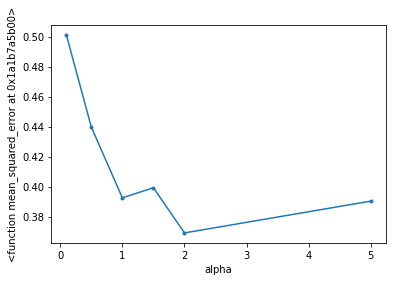

Train:  0.14593860150392937
Test:  0.5116060372370144


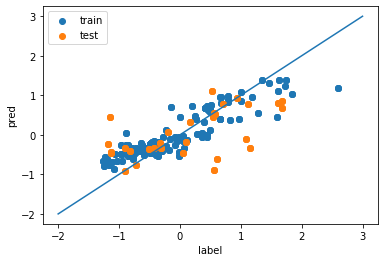

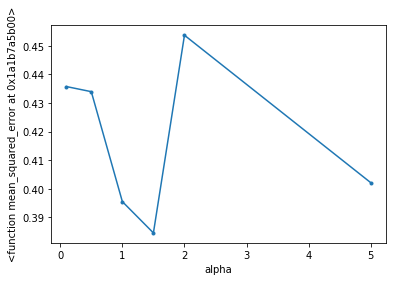

Train:  0.1207987721638497
Test:  0.6534356534797521


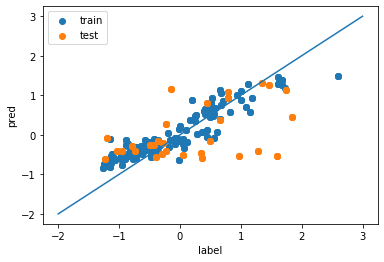

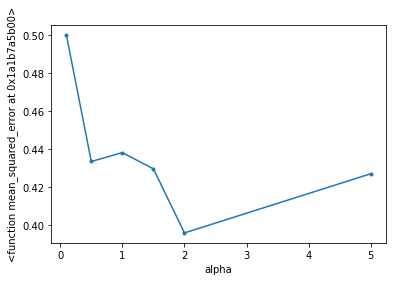

Train:  0.14962557001326826
Test:  0.3437046442810785


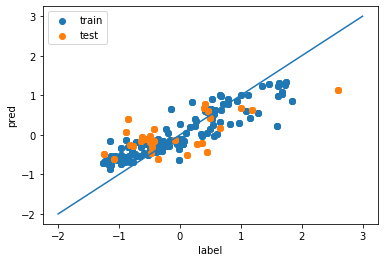

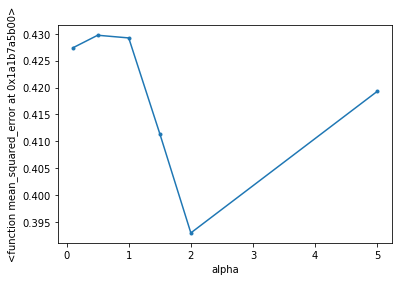

Train:  0.15684169555250765
Test:  0.3102327257858587


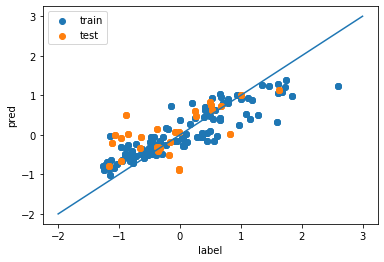

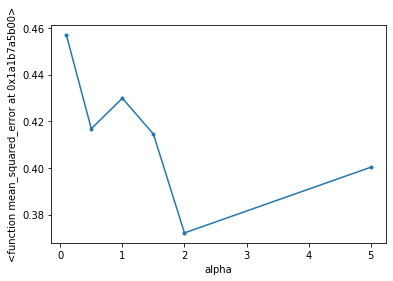

Train:  0.1592498727716129
Test:  0.28710611174277106


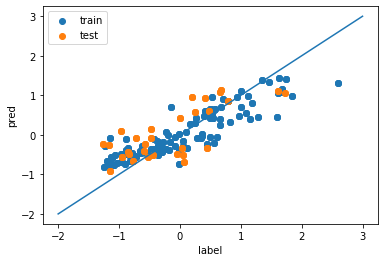

Cross-validation Test mean:  0.4212170345052949
Cross-validation Test std:  0.14029047425798866


In [7]:
kernel = Spectrum_Kernel
optimal_para, test_scores = cross_val(df, cv, random_state, test_size, alpha_list, kernel, embedding, eva_metric, eva_on_ave_flag)

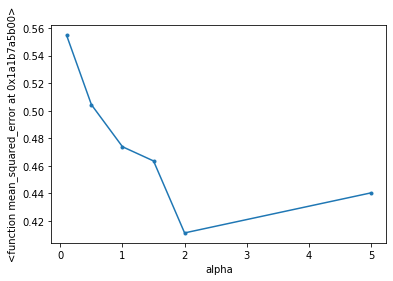

Train:  0.2282703532352418
Test:  0.4956089355345569


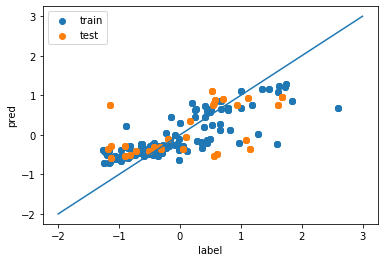

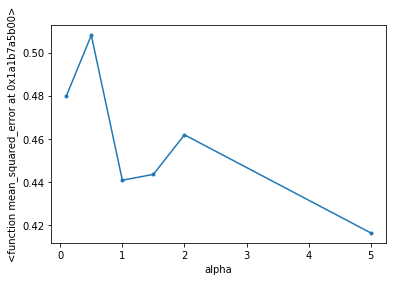

Train:  0.24932508530009836
Test:  0.694381889999284


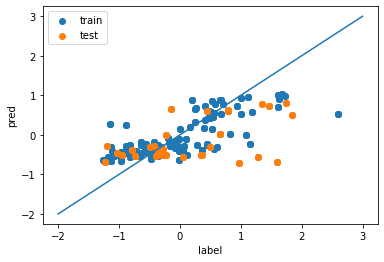

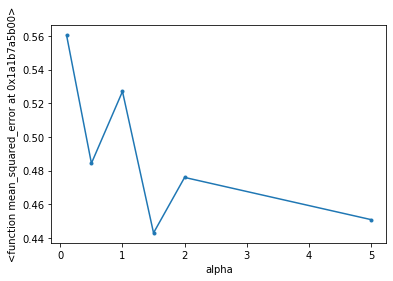

Train:  0.2112109671425008
Test:  0.4889406698428707


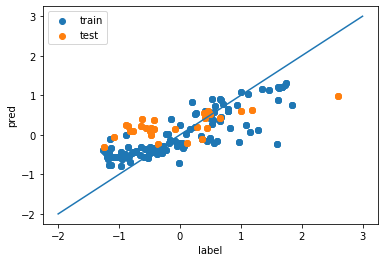

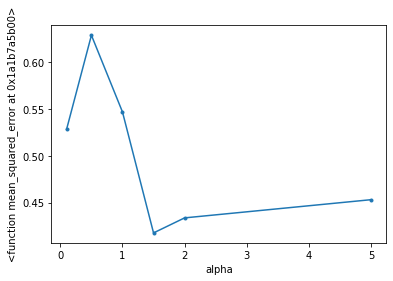

Train:  0.239776404720783
Test:  0.272339516210951


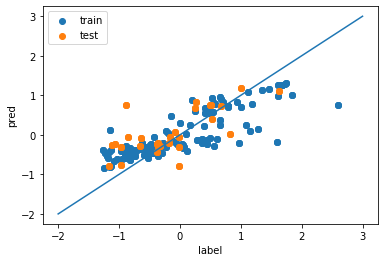

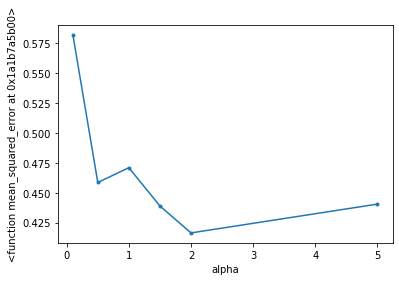

Train:  0.2431014362413582
Test:  0.2941920812448398


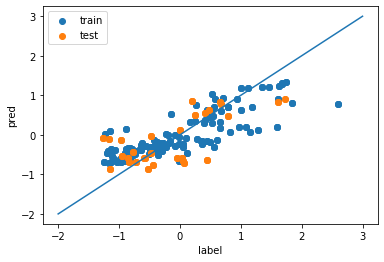

Cross-validation Test mean:  0.4490926185665005
Cross-validation Test std:  0.1543724698705525


In [9]:
kernel = Sum_Spectrum_Kernel
optimal_para, test_scores = cross_val(df, cv, random_state, test_size, alpha_list, kernel, embedding, eva_metric, eva_on_ave_flag)

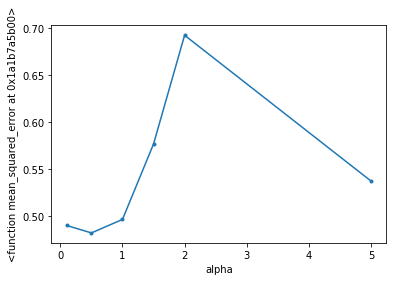

Train:  0.09709630401257154
Test:  0.6886072415037617


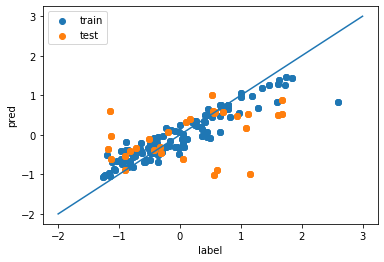

/Users/zhangmengyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.21973631e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)


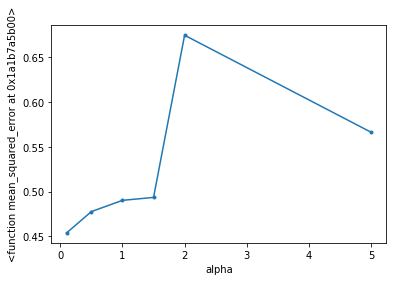

Train:  0.001209889190913852
Test:  0.6981177349534711


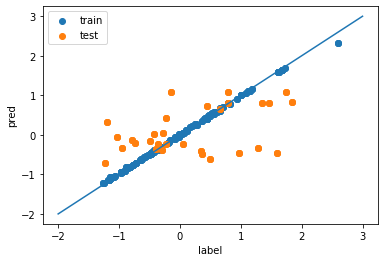

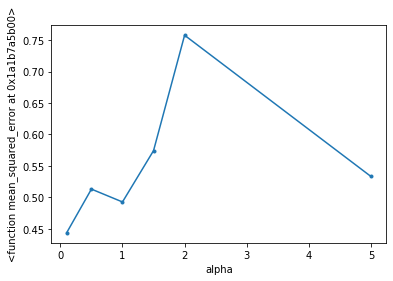

Train:  0.0022474106276632105
Test:  0.4255880378936438


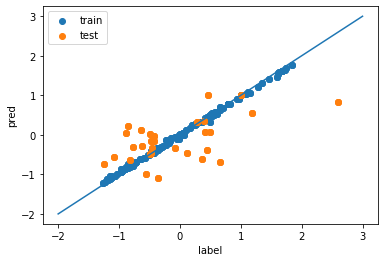

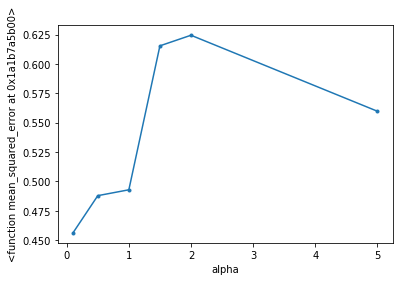

Train:  0.0010193619758719261
Test:  0.3720070515567696


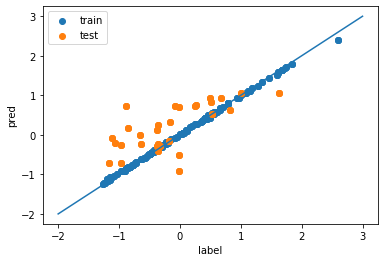

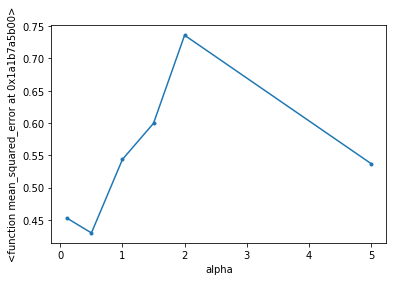

Train:  0.05585637841080702
Test:  0.3850989715819991


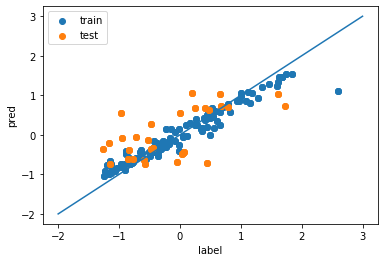

Cross-validation Test mean:  0.5138838074979291
Cross-validation Test std:  0.14763543557342718


In [10]:
embedding = 'onehot'
kernel = RBF
optimal_para, test_scores = cross_val(df, cv, random_state, test_size, alpha_list, kernel, embedding, eva_metric, eva_on_ave_flag)

## Cross Validation for samples

In [11]:
Path = '../../data/firstRound_4h+Baseline.csv'

df_samples = pd.read_csv(Path)
df_samples.head()

,Unnamed: 0,AVERAGE,Group,RBS,RBS6,STD,label,variable
0,0,2.592357,bps,TTTAAGAAGGAGATATACAT,AGGAGA,0.717515,3.194925,Rep1
1,1,1.604161,bps,CTTAAGAAGGAGATATACAT,AGGAGA,0.284382,1.844257,Rep1
2,2,0.662662,bps,GTTAAGAAGGAGATATACAT,AGGAGA,0.017069,0.674610,Rep1
3,3,1.678999,bps,ATTAAGAAGGAGATATACAT,AGGAGA,0.500712,1.986839,Rep1
4,4,1.671743,bps,TCTAAGAAGGAGATATACAT,AGGAGA,0.624388,1.830061,Rep1


In [12]:
df_samples.shape

(562, 8)

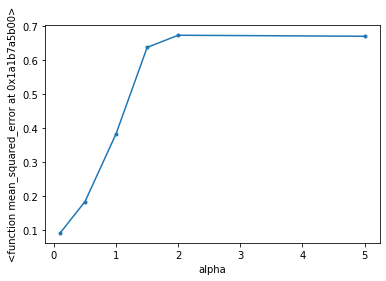

Train:  0.009391569298418513
Test:  0.07244716088006631


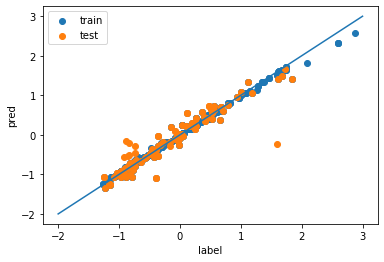

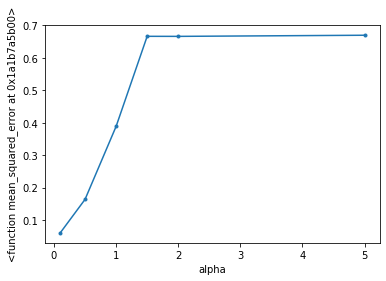

Train:  0.01588390019902234
Test:  0.14181283316990004


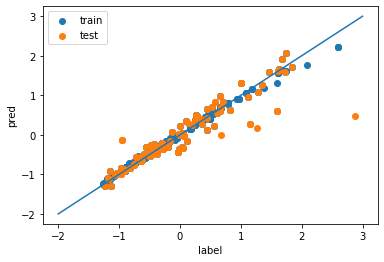

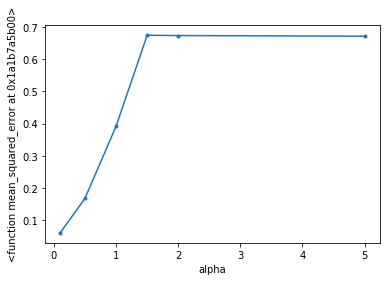

Train:  0.016457464014756593
Test:  0.0697372036981121


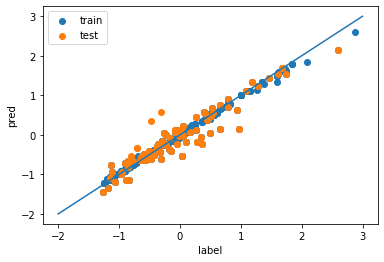

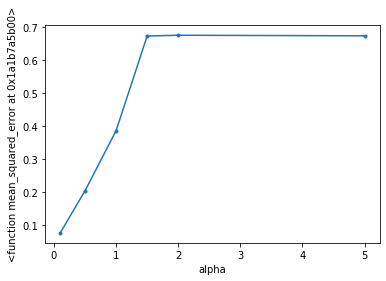

Train:  0.02137685105643528
Test:  0.13949697978753275


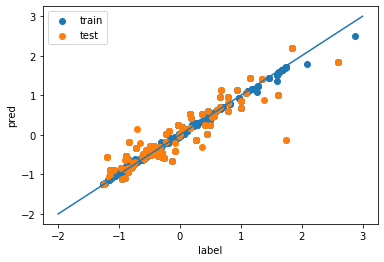

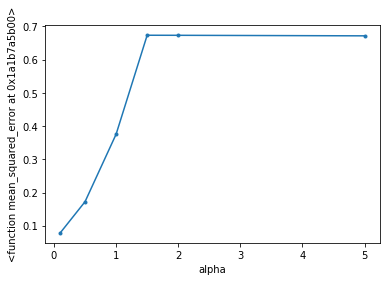

Train:  0.01687264937985711
Test:  0.15505603914695776


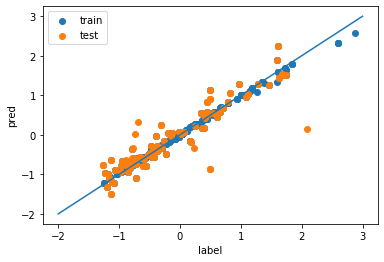

Cross-validation Test mean:  0.11571004333651377
Cross-validation Test std:  0.03682515540221062


In [13]:
optimal_para, test_scores = cross_val(df_samples, cv, random_state, test_size, alpha_list, kernel, embedding, eva_metric, eva_on_ave_flag)

In [14]:
cross_val_with_optimal_para(df_samples, optimal_para, cv, random_state, kernel, embedding, eva_metric, eva_on_ave_flag)

Mean: 0.12826629191267755
STD: 0.03884504169220836


[0.12256828203452758,
 0.18088219517483717,
 0.08886813729331655,
 0.16427637289949018,
 0.08473647216121624]

## What if we drop bps group

In [15]:
df_samples_no_bps = df_samples[df_samples['Group'] != 'bps'].reset_index()
df_samples_no_bps.shape

(383, 9)

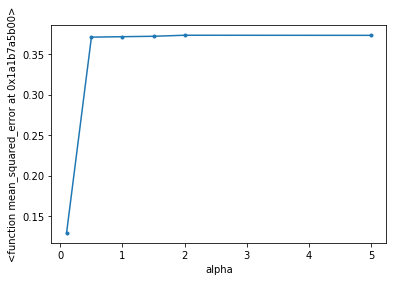

Train:  0.016606944091336166
Test:  0.1572242455978986


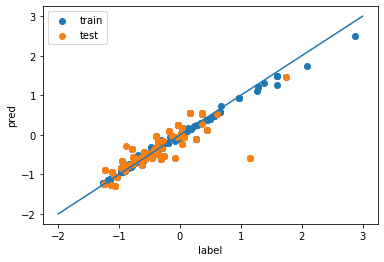

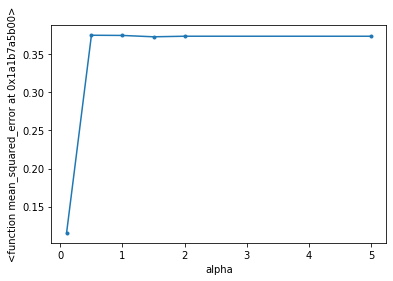

Train:  0.012243908931493741
Test:  0.12992551844013855


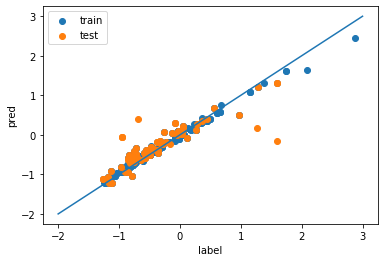

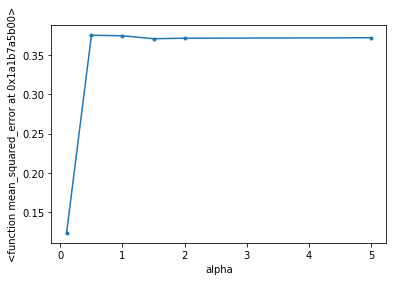

Train:  0.018515004433708068
Test:  0.15086032567615246


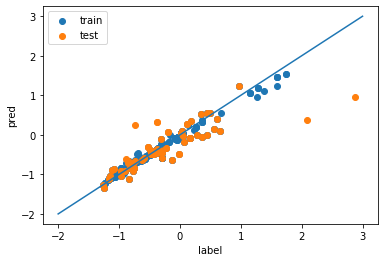

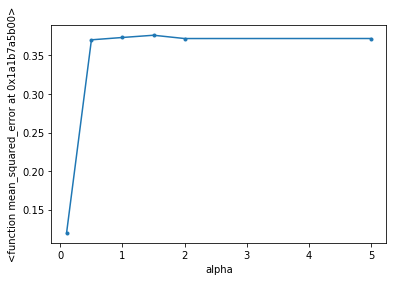

Train:  0.013297430125455678
Test:  0.0647808297759425


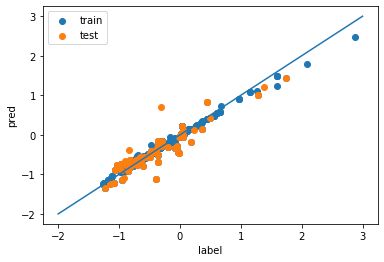

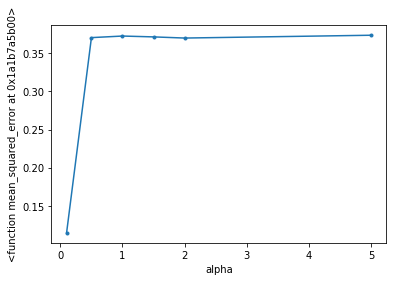

Train:  0.017745410444381587
Test:  0.07308641085792265


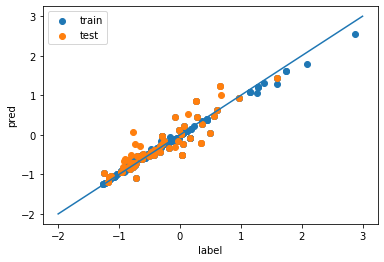

Cross-validation Test mean:  0.11517546606961096
Cross-validation Test std:  0.03891061820550812


In [16]:
optimal_para, test_scores = cross_val(df_samples_no_bps, cv, random_state, test_size, alpha_list, kernel, embedding, eva_metric, eva_on_ave_flag)

## Normalise replicates?

In [17]:
num_data = df.shape[0]
sorted_df = df.sort_values(['AVERAGE'])

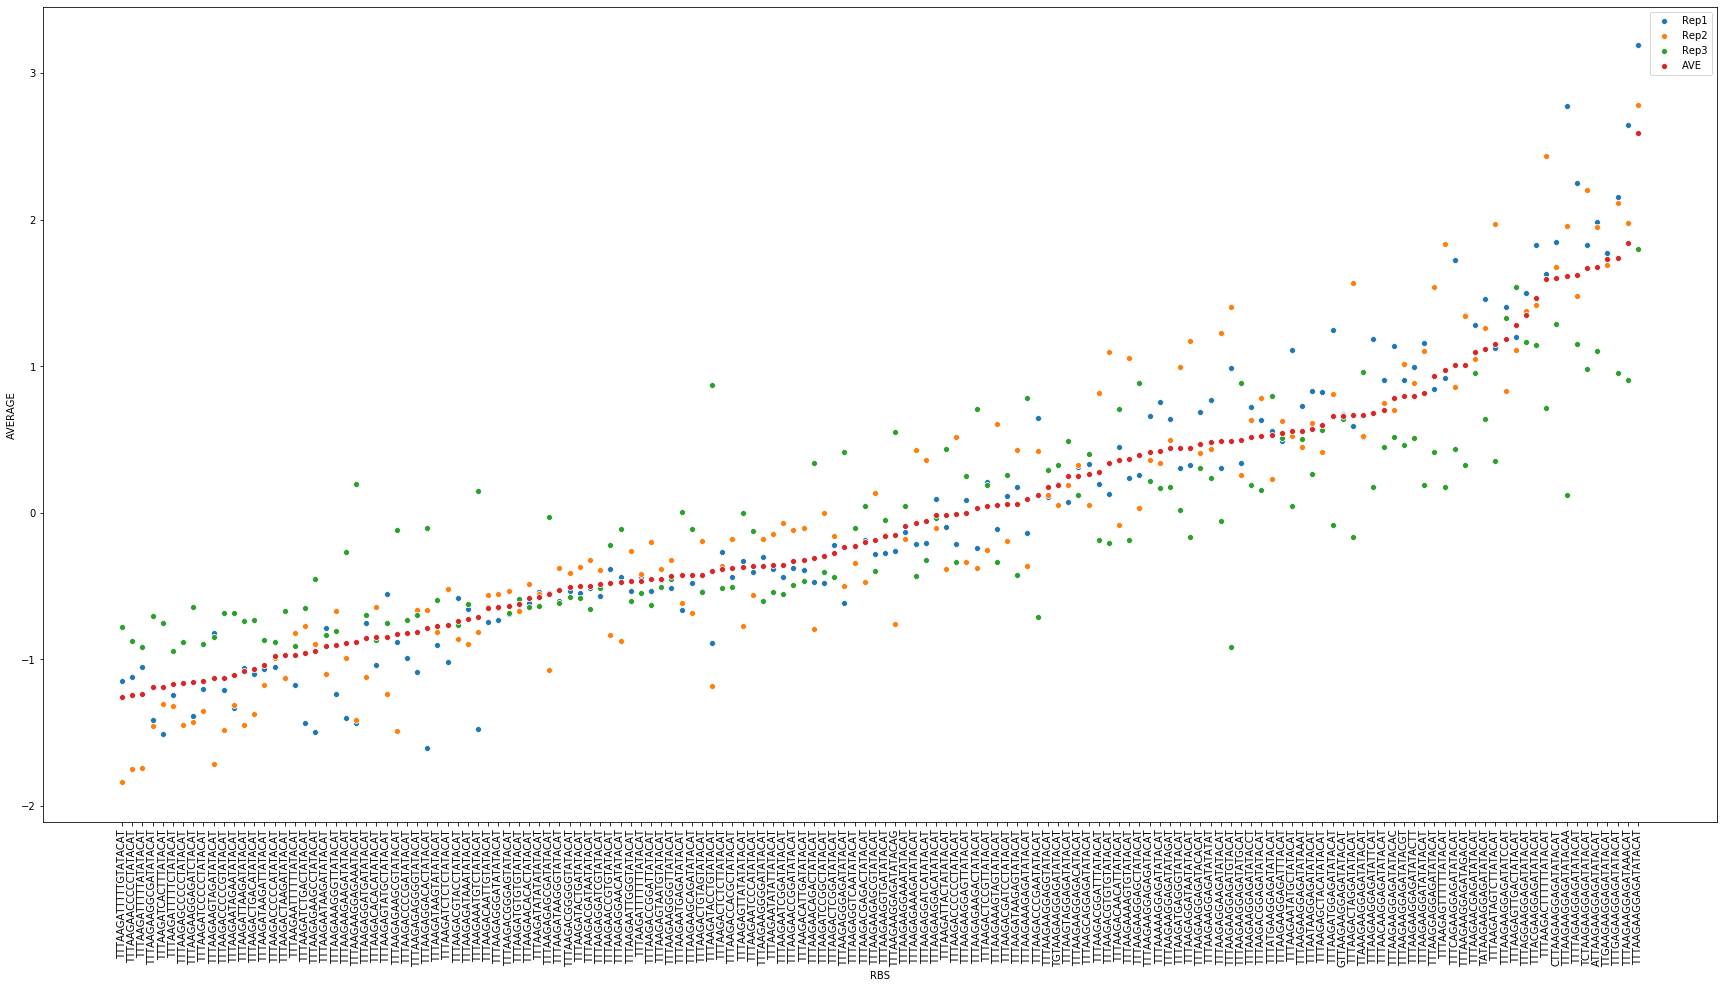

In [18]:
plt.figure(figsize = (30,15))
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep1'], label = 'Rep1')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep2'], label = 'Rep2')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep3'], label = 'Rep3')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['AVERAGE'], label = 'AVE')
labels = sorted_df['RBS']
ax.set_xticklabels(labels, rotation = 90)
plt.show()

[ 0.02173667 -1.61938168]
[ 0.02146547 -1.59917732]
[ 0.01188477 -0.94332214]
[ 0.01844038 -1.39109994]


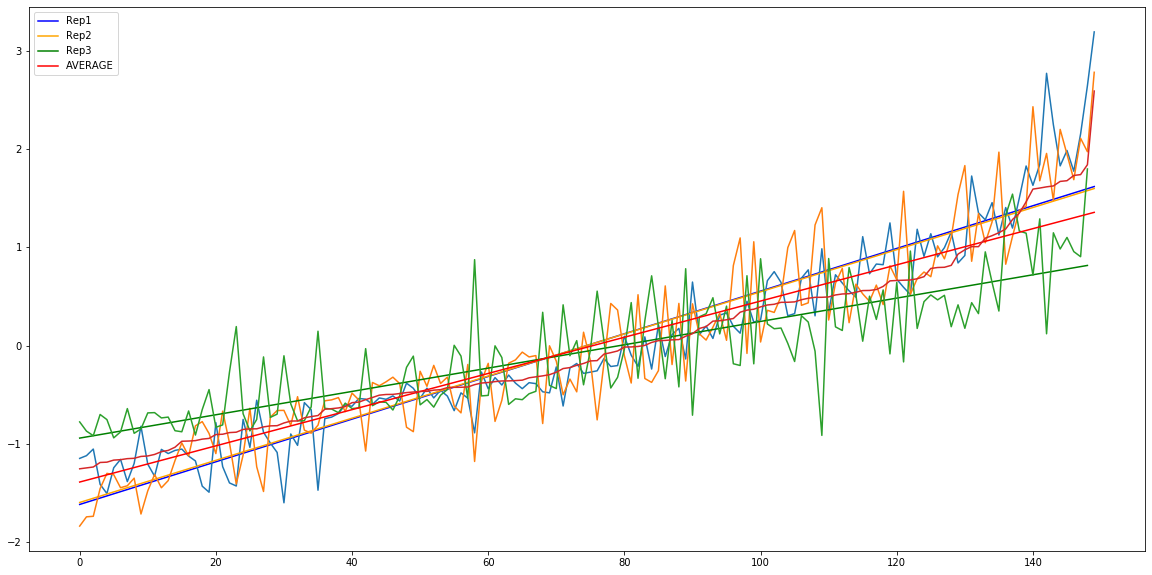

In [19]:
# fit curve

from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x + b

plt.figure(figsize = (20,10))

color_list = ['blue', 'orange', 'green', 'red']
popt_dict = {}

for i, rep in enumerate(['Rep1', 'Rep2', 'Rep3', 'AVERAGE']):
    ydata = np.asarray(sorted_df[rep].dropna())
    xdata = range(len(ydata))
    popt, pcov = curve_fit(func, xdata, ydata)
    print(popt)
    popt_dict[rep] = popt
    plt.plot(xdata, func(xdata, *popt), label = rep, color = color_list[i])
    plt.plot(xdata, ydata)
    plt.legend()

In [20]:
# normalise?

popt_dict

{'Rep1': array([ 0.02173667, -1.61938168]),
 'Rep2': array([ 0.02146547, -1.59917732]),
 'Rep3': array([ 0.01188477, -0.94332214]),
 'AVERAGE': array([ 0.01844038, -1.39109994])}

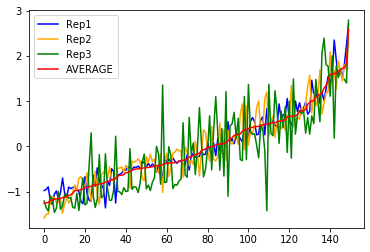

In [21]:
df_normalised = sorted_df

for i, rep in enumerate(['Rep1', 'Rep2', 'Rep3', 'AVERAGE']):
    ratio = popt_dict[rep][0]/popt_dict['AVERAGE'][0]
    df_normalised[rep] = sorted_df[rep]/ratio
    normalised_rep = np.asarray(df_normalised[rep])
    
    xdata = range(len(normalised_rep))
    
    plt.plot(xdata, normalised_rep, label = rep, color = color_list[i])
    plt.legend()

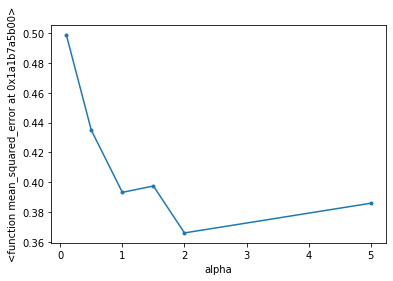

Train:  0.14916792330773435
Test:  0.49407136816318376


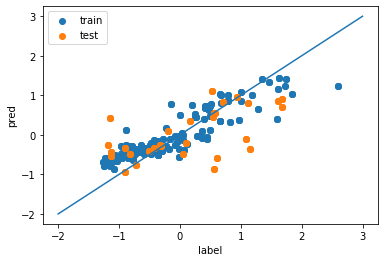

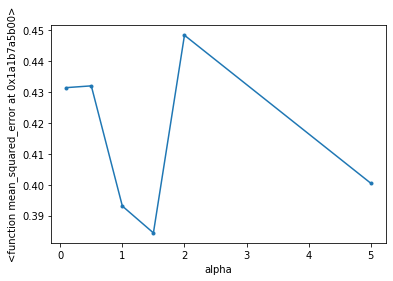

Train:  0.12462813195794749
Test:  0.6538455703898738


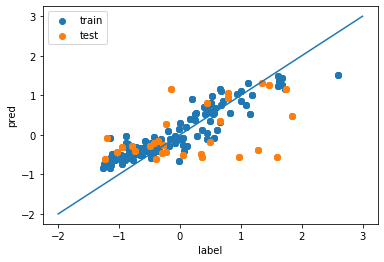

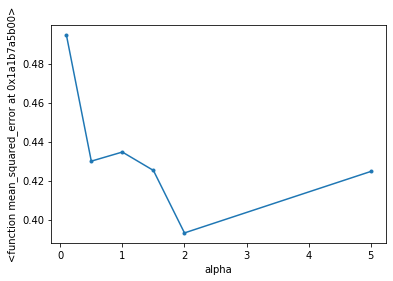

Train:  0.15411163949373105
Test:  0.34481934789647833


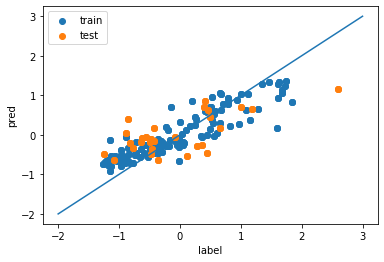

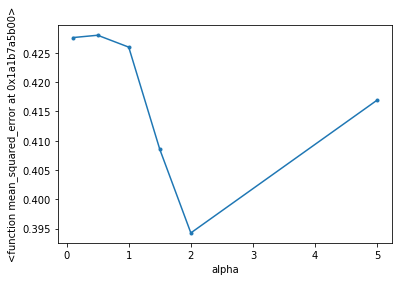

Train:  0.1603426083174687
Test:  0.30338900563073906


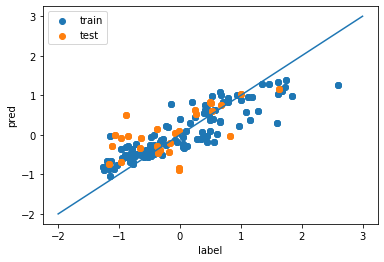

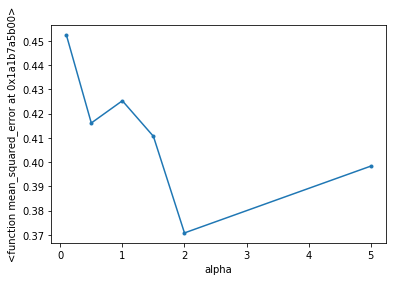

Train:  0.16294180587650747
Test:  0.288988371866503


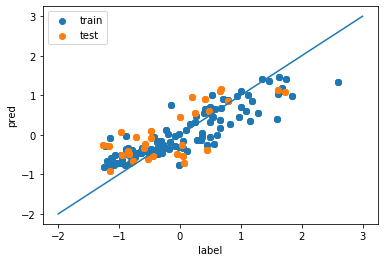

Cross-validation Test mean:  0.41702273278935553
Cross-validation Test std:  0.1389534446762668


In [23]:
embedding = 'label'
kernel = Spectrum_Kernel
optimal_para, test_scores = cross_val(df_normalised, cv, random_state, test_size, alpha_list, kernel, embedding, eva_metric, eva_on_ave_flag)